# Information contained within subsections of the TCR sequence

In [1]:
import pandas as pd
import numpy as np
import pyrepseq as prs
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize
import seaborn as sns

from src import *

sns.set_theme()
sns.set_style("ticks")

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
mpl.rcParams['font.family'] = 'serif'

Matplotlib is building the font cache; this may take a moment.
/Users/james/Documents/Projects/TCR-info 2022/paper_tcrinfo/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
olga = pd.read_csv('data/olga.csv.gz',sep=',').astype(str)
spc = pd.read_csv('data/spc.csv.gz',sep=',').astype(str)
epitope_meta = pd.read_csv('data/epitope_meta.csv.gz',sep=',')

## Cental heatmap - The alpha and beta chains

In [3]:
alpha_beta_grid = np.zeros((2,2))
alpha_beta_grid[0 ,1] = alpha_beta_grid[1 ,0] = prs.renyi2_entropy(olga, "Alpha")  + prs.renyi2_entropy(olga, "Beta") - prs.renyi2_entropy(spc, "Full sequence", "Epitope")
alpha_beta_grid[0 ,0] = prs.renyi2_entropy(olga, "Alpha") - prs.renyi2_entropy(spc, "Alpha", "Epitope")
alpha_beta_grid[1 ,1] = prs.renyi2_entropy(olga, "Beta") - prs.renyi2_entropy(spc, "Beta", "Epitope")

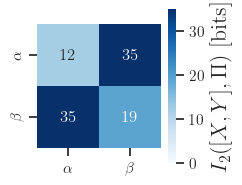

In [4]:
plot_grid(alpha_beta_grid, ["$\\alpha$", "$\\beta$"], ["$\\alpha$", "$\\beta$"], save_path='figures/', save_file_name='figure2_central.svg', vmin=0, vmax=35, cbar_kws = {'label': '$I_2([X, Y], \Pi)$ [bits]'})

## Top left heatmap and bottom right - Breaking down the Chains into V, J and CDR3 regions

In [5]:
alpha_grid = get_relevancy_grid(olga, spc, ["CDR3A", "TRAV", "TRAJ"])
beta_grid = get_relevancy_grid(olga, spc, ["CDR3B", "TRBV", "TRBJ"])

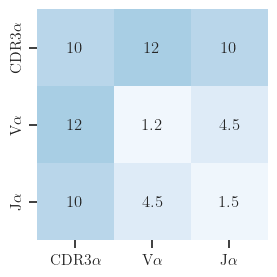

In [6]:
plot_grid(alpha_grid, ["CDR3$\\alpha$", "V$\\alpha$", "J$\\alpha$"], ["CDR3$\\alpha$", "V$\\alpha$", "J$\\alpha$"], save_path='figures/', save_file_name='figure2_topleft.svg', vmin=0, vmax=36, cbar=False)

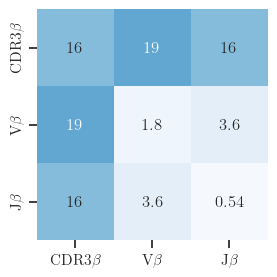

In [7]:
plot_grid(beta_grid, ["CDR3$\\beta$", "V$\\beta$", "J$\\beta$"], ["CDR3$\\beta$", "V$\\beta$", "J$\\beta$"], save_path='figures/', save_file_name='figure2_bottomright.svg', vmin=0, vmax=36, cbar=False)

## Top right heatmap - Joint across chain information

In [8]:
alpha_beta_cross_grid = get_cross_relevancy_grid(olga, spc, ["CDR3A", "TRAV", "TRAJ"], ["CDR3B", "TRBV", "TRBJ"])

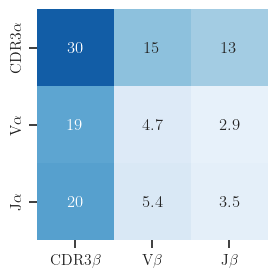

In [9]:
plot_grid(alpha_beta_cross_grid, ["CDR3$\\alpha$", "V$\\alpha$", "J$\\alpha$"], ["CDR3$\\beta$", "V$\\beta$", "J$\\beta$"], save_path='figures/', save_file_name='figure2_topright.svg', vmin=0, vmax=36, cbar=False)

## Priors for 95% confidence in classification

In [10]:
def compute_priors_from_T(i2, posterior_p):
    
    T = posterior_p/(1-posterior_p)
    
    return T*2**(-i2)/(1+T*2**(-i2))

In [11]:
print(f"Alpha chain: {compute_priors_from_T(alpha_beta_grid[0,0], 0.95)}")
print(f"Beta chain: {compute_priors_from_T(alpha_beta_grid[1,1], 0.95)}")
print(f"CDR3A: {compute_priors_from_T(alpha_grid[0,0], 0.95)}")
print(f"CDR3B: {compute_priors_from_T(beta_grid[0,0], 0.95)}")

Alpha chain: 0.0034923384075237793
Beta chain: 3.4723639889171475e-05
CDR3A: 0.013168828143749981
CDR3B: 0.00037167044865526496


# Synergistic and redundant sequence features

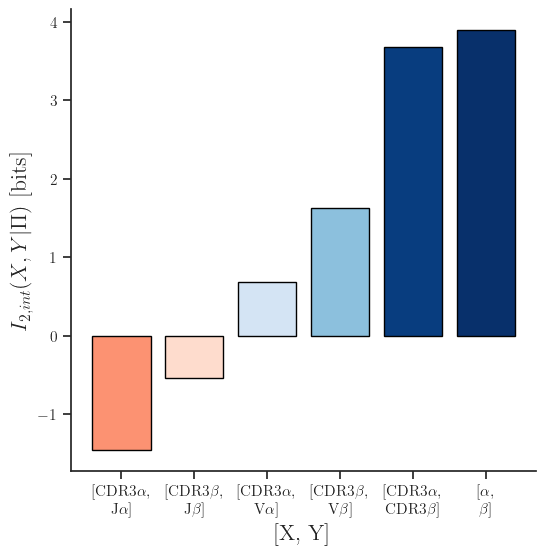

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

values = [
    alpha_grid[0, 2] - alpha_grid[0, 0] - alpha_grid[2, 2],
    beta_grid[0, 2] - beta_grid[0, 0] - beta_grid[2, 2],
    alpha_grid[0, 1] - alpha_grid[0, 0] - alpha_grid[1, 1],
    beta_grid[0, 1] - beta_grid[0, 0] - beta_grid[1, 1],
    alpha_beta_cross_grid[0, 0] - alpha_grid[0, 0] - beta_grid[0, 0],
    alpha_beta_grid[0, 1] - alpha_beta_grid[0, 0] - alpha_beta_grid[1, 1]
]

norm_blue = Normalize(vmin=0, vmax=max(values))
norm_red = Normalize(vmin=-max(values), vmax=0)
cmap_reds = plt.get_cmap('Reds_r')
cmap_blues = plt.get_cmap('Blues')

for i, value in enumerate(values):
    if value < 0:
        color = cmap_reds(norm_red(value))
    else:
        color = cmap_blues(norm_blue(value))
    ax.bar(i, value, color=color, edgecolor='black')

ax.set_ylabel("$I_{2, int}(X, Y|\Pi)$ [bits]")
ax.set_xlabel("[X, Y]")
bars = ["[CDR3$\\alpha$, \n J$\\alpha$]", "[CDR3$\\beta$, \n J$\\beta$]",
        "[CDR3$\\alpha$, \n V$\\alpha$]", "[CDR3$\\beta$, \n V$\\beta$]",
       "[CDR3$\\alpha$, \n CDR3$\\beta$]", '[$\\alpha$, \n $\\beta$]']
ax.set_xticks(np.arange(len(bars)), bars);
plt.savefig('figures/figure3.svg', bbox_inches='tight', dpi=500)
plt.show()